# Zdefiniowanie problemu

# Kamień milowy 1
### Zuzanna Glinka
### Karol Degórski
### Adrian Kamiński

#### Wybrany problem 

W ramach projektu zajmiemy się przede wszystkim analizą wyjaśniem związanych z kształtem.

Na poniższym ryskunku prezentujemy postawiony przez nas problem. Naszym celem jest wykrywanie czy duża figura (kwadrat, trójkąt lub okrąg) jest złożona z tylko i wyłącznie takich samych małych figur. Będzie to zatem problem klasyfikacji na 4 klasy:
- 0: błędny
- 1: trójkąt
- 2: kwadrat
- 3: koło

Przykładowo na pierwszym obrazku oczekujemy, że model zaklasyfikuje go jako kwadrat (klasa 2), ponieważ duży kwadrat składa się tylko i wyłącznie z małych kwadratów. Natomiast rysunek drugi powinien zostać zaklasyfikowany jako błędny (klasa 0), z uwagi na fakt, że figury tworzące duży kwadrat są nie tylko kwadratami (jest widoczny jeden okrąg). W takiej sytuacji dokonamy wyjaśnienia zaznaczając mały okrąg. Ponadto chcemy również, żeby model w sytuacji gdy nie będzie widoczna żadna duża figura zaklasyfikował ją jaką niepoprawną (klasa 0). 

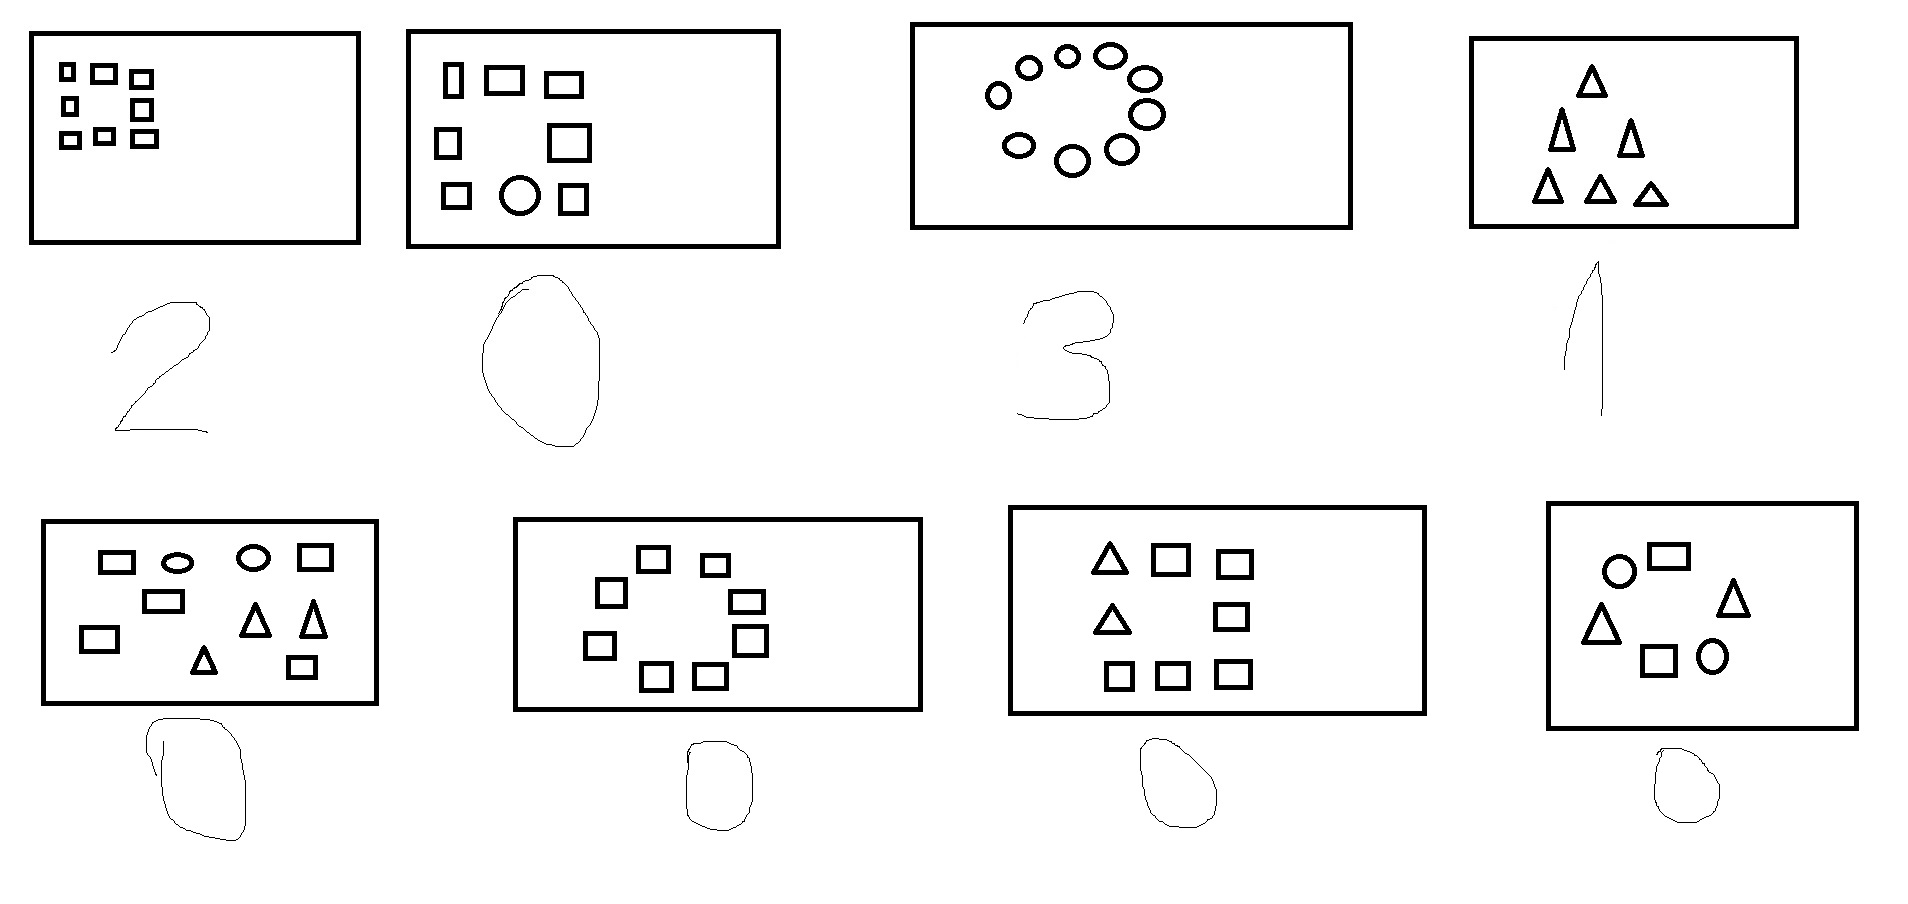

Ewentualne rozszerzenia postawionego przez nas problemu:
- dodanie szumu (losowo rozmieszczone kształty)
- wiele dużych figur (do zastanowienia się, potencjalne problemy)
    - na którą figurę model powinnien patrzeć
    - nie wystarczy już sprawdzać, czy wszystkie małe figury mają taki sam kształt
    - nakładające się duże figury, w taki sposób, że części wspólne są puste

#### Wstępne podejście do modelowania danych związanych z artykułem

Przygotowanie funkcji generujących dane

In [1]:
import numpy as np
import os
import math
import random
import warnings
warnings.filterwarnings("ignore")


from PIL import Image, ImageFont, ImageDraw, ImageEnhance, ImageChops

WIDTH   = 120

kandinsky_colors = ['red','yellow', 'blue']
kandinsky_numbers = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']


def square (d,cx,cy,s,f):
  s = 0.7 * s
  d.rectangle(((cx-s/2, cy-s/2), (cx+s/2, cy+s/2)), fill=f)

def circle (d,cx,cy,s,f):
  # correct the size to  the same area as an square
  s = 0.7 * s * 4 / math.pi 
  d.ellipse(((cx-s/2, cy-s/2), (cx+s/2, cy+s/2)), fill=f)

def triangle (d,cx,cy,s,f):
  r = math.radians(30)
  # correct the size to  the same area as an square
  s = 0.7 * s * 3 * math.sqrt(3) / 4
  dx = s * math.cos (r) / 2
  dy = s * math.sin (r) / 2
  d.polygon([(cx,cy-s/2), (cx+dx, cy+dy), (cx-dx,cy+dy)], fill = f)

kandinsky_shapes = [square, circle, triangle]

def kandinskyFigure (shapes, subsampling = 1):
  image = Image.new("RGBA", (subsampling*WIDTH,subsampling*WIDTH), (220,220,220,255))
  d = ImageDraw.Draw(image)
  for s in shapes:
      s['shape']( d, subsampling*s['cx'], subsampling*s['cy'], subsampling*s['size'], s['color'] )
  if subsampling>1:
    image = image.resize( (WIDTH,WIDTH), Image.BICUBIC)
  return image

def overlaps (shapes):
  image = Image.new("L", (WIDTH,WIDTH), 0)
  sumarray = np.array(image)
  d = ImageDraw.Draw(image)
  
  for s in shapes:
    image      = Image.new("L", (WIDTH,WIDTH), 0)
    d = ImageDraw.Draw(image)
    s['shape']( d, s['cx'], s['cy'], s['size'], 10 )
    sumarray = sumarray + np.array(image)

  sumimage = Image.fromarray (sumarray)
  return sumimage.getextrema ()[1] > 10

def combineFigures (n, f):
  images = []
  for i in range (n):
    shapes = f()
    while overlaps (shapes):
      shapes = f()
    image = kandinskyFigure (shapes,4)    
    images.append (image)
  
  allimages = Image.new("RGBA", (WIDTH*n+20*(n-1),WIDTH), (255,255,255,255))
  for i in range (n):
    allimages.paste ( images[i], ( WIDTH*i+20*(i), 0))
  return allimages

In [2]:
def combineFigures (n, f):
  images = []
  for i in range (n):
    shapes = f()
    while overlaps (shapes):
      shapes = f()
    image = kandinskyFigure (shapes,4)    
    images.append (image)
  
  allimages = Image.new("RGBA", (WIDTH*n+20*(n-1),WIDTH), (255,255,255,255))
  for i in range (n):
    allimages.paste ( images[i], ( WIDTH*i+20*(i), 0))
  return allimages

In [3]:
def drawTrang2 (nshapes):
  dx =  math.cos (random.random()* math.pi * 2) * (WIDTH/4-MAXSIZE/4)
  if abs(dx) < 0.1:
    dx = dx + 0.1 if dx>0 else dx - 0.1
  dy =  math.sin (random.random()* math.pi * 2) * (WIDTH/4-MAXSIZE/4)
  sx = WIDTH/2  - dx  
  sy = WIDTH/2  + dx
  ex = WIDTH/2  + dx  
  ey = WIDTH/2  - dx   
  dx =  ex-sx
  dy =  ey-sy
  shapes = []
  r = 0.1 # 0.07
  move = 20
  if dx > 0:
    move *= -1
  maks_r = r * nshapes
  for i in range (nshapes):
    cx = sx + r * i * dx + random.random() * WIDTH/32 - move
    cy = sy - r * i * dx * math.sqrt(3) + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  for i in range (1, nshapes):
    cx = sx - r * i * dx + random.random() * WIDTH/32 - move
    cy = sy - r * i * dx * math.sqrt(3) + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  for i in range (nshapes + 1):
    cx = sx - maks_r * dx + r * i * dx * 2 + random.random() * WIDTH/32 - move
    cy = sy - maks_r * dx * math.sqrt(3) + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  return shapes

In [4]:
MINSIZE = 5
MAXSIZE = 10
def drawSquare2 (nshapes):
  dx =  math.cos (random.random()* math.pi * 2) * (WIDTH/2-MAXSIZE/2)
  if abs(dx) < 0.1:
      dx = dx + 0.1 if dx>0 else dx - 0.1
  dy =  math.sin (random.random()* math.pi * 2) * (WIDTH/2-MAXSIZE/2)
  sx = WIDTH/2  - dx  
  sy = WIDTH/2  - dx
  ex = WIDTH/2  + dx  
  ey = WIDTH/2  + dx 
  dx =  ex-sx
  dy =  ey-sy
  shapes = []
  const = 0.15
  maks_r = const * nshapes
  for i in range (nshapes):
    r = const * i
    while r > maks_r:
      r = random.random()
    cx = sx + random.random() * WIDTH/32
    cy = sy + r * dx + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  for i in range (1, nshapes):
    r = const * i
    while r > maks_r:
      r = random.random()
    cx = sx + r * dx + random.random() * WIDTH/32
    cy = sy + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  for i in range (nshapes+1):
    r = const * i
    while r > maks_r:
      r = random.random() 
    cx = sx + maks_r * dx + random.random() * WIDTH/32
    cy = sy + r * dx + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  for i in range (nshapes):
    r = const * i
    while r > maks_r:
      r = random.random() 
    cx = sx + r * dx + random.random() * WIDTH/32
    cy = sy + maks_r * dx + random.random() * WIDTH/32
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  
  
  
  return shapes


In [5]:
MINSIZE = 5
MAXSIZE = 10
def drawCircle2 (nshapes):
  nshapes = random.randint(6, 20)
  r = random.random()
  dx =  math.cos (random.random() * math.pi * 2) * (WIDTH/4-MAXSIZE/4)
  dy =  math.sin (random.random() * math.pi * 2) * (WIDTH/4-MAXSIZE/4)
  sx = WIDTH/2  - dx  
  sy = WIDTH/2  + dy  
  ex = WIDTH/2  + dx  
  ey = WIDTH/2  - dy  
  dx =  ex-sx
  dy =  ey-sy
  shapes = []
    
  fis = np.radians(np.arange(0, 360, step = 360/nshapes) + np.random.uniform(-90/nshapes, 90/nshapes, size = nshapes))

  for i in range (nshapes):
    # fi = 0.1 * i * math.pi * 2 
    fi = fis[i]
    cx = sx + r * dx + math.cos(fi) * WIDTH/4 + random.random() * WIDTH/16
    cy = sy + r * dy + math.sin(fi) * WIDTH/4 + random.random() * WIDTH/16
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append(shape)
  return shapes

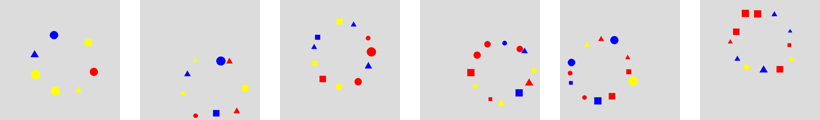

In [6]:
combineFigures(6, lambda:drawCircle2(10))

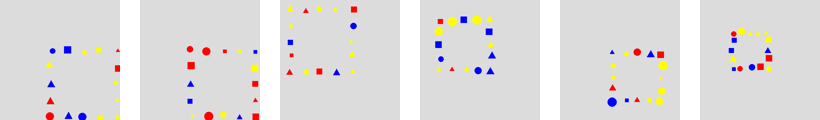

In [7]:
combineFigures(6, lambda: drawSquare2(4))

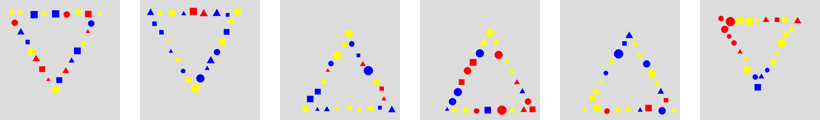

In [8]:
combineFigures(6, lambda: drawTrang2(8))

#### Streszczenia artykułów z dziedziny


1.   **[Kandinsky Patterns](https://reader.elsevier.com/reader/sd/pii/S0004370221000977?token=C89339E5F656ACF6ED35439ACCB2B311B6D3F00EEA8C66AD648181617C7625B7FC2BDBECE451EF7483A22E1E371DF83F&originRegion=eu-west-1&originCreation=20220419221759)** \
Przedstawiona została główna idea oraz podstawowe zasady wzorów Kandinsky'ego, które mają tę własność, że mogą być łatwo opisane zarówno przez człowieka jak i komputer. Zaletą tego artykułu jest to, że wiele podanych pojęć, które mogłyby być obce dla czytelnika nieobytego z pojęciami sztucznej inteligencji, jest tłumaczonych w przystępny sposób. Natomiast do wad artykułu możemy zaliczyć to, że w sekcji *Data sets and challenges* wizualizacje problemów są rozmieszczone w mało intuicyjnych miejscach względem ich wyjaśnień, co może powodować lekką dezorientację. W tekście został zawarty odnośnik do pliku generującego zbiór danych, dzięki czemu umożliwia osobom zainteresowanym pracę nad problemem. Zbiór jest prosty co umożliwia łatwiejsze zrozumienie problemu oraz tłumaczeń klasyfikacji.  

1.   **[Explainable artificial intelligence: understanding, visualizing and interpreting deep learning models](https://arxiv.org/abs/1708.08296)**  \
Artykuł w przystępny sposób prezentuje powody, dla których istotna jest możliwość wyjaśniania predykcji modeli uczenia maszynowego oraz tłumaczy działanie dwóch popularnych metod wyjaśnień: Sensitivity Analysis (analiza wrażliwości) i Layer-Wise Relevance Propagation. Sensitivity Analysis działa na podstawie lokalnej ewaluacji gradientu modelu. Zaletą tej metody jest to, że wskazuje, które piksele należy zamienić, aby obraz wyglądał dla modelu bardziej/mniej jak przewidywana klasa, natomiast wadą jest to, że nie wskazuje ona, które piksele są rzeczywiście istotne dla predykcji danej klasy. Z kolei Layer-Wise Relevance Propagation za pomocą dekompozycji wykrywa piksele, które są kluczowe dla predykcji danej klasy, co jest główną zaletą tej metody. Na przeprowadzonych testach (klasyfikacja obrazów, klasyfikacja dokumentów tekstowych, klasyfikacja ludzkich zachowań w filmach) metoda LRP okazała się lepiej wyjaśniać predykcje od metody SA.

1. **[Darpa's explainable artificial intelligence program](https://doi.org/10.1609/aimag.v40i2.2850)** \
Artykuł przedstawia zmagania 12 zespołów, których celem było stworzenie wyjaśnialnych modeli w dziedzinach takich jak Autonomy, Analytics albo obydwu tych kategoriach. Oprócz tego jeden z zespołów zajmował się stworzeniem frameworku do ewaluacji efektywności wyjaśnienia. Artykuł ten jest wybitnie fachowy, obejmuje dziedziny takie jak ML, DNN, RL..., co zdecydowanie utrudnia wgłębienie się w konkretny temat. Ale za to uświadamia nas, że kwestia tworzenia eXplainable Artificail Intelligence (XAI) jest tematem otwartym i jest wiele możliwych podejść do tworzenia wyjaśnialnych modeli.


# Tworzenie danych

### Generowanie danych z korzystając z [app-kandinsky-pattern-generator](https://github.com/human-centered-ai-lab/app-kandinsky-pattern-generator)

In [1]:
!pip install inflect

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [4]:
import os

from PIL import Image
from kp import KandinskyUniverse, RandomKandinskyFigure, SimpleObjectAndShape, ShapeOnShapes, NumbersKandinskyFigure,  KandinskyCaptions, DrawBigSquare, DrawBigCircle, DrawBigTriangle
import cv2

u  = KandinskyUniverse.SimpleUniverse()
cg = KandinskyCaptions.CaptionGenerator (u)


def generateImagesAndCaptions (basedir, kfgen, n=50, width=200):
    os.makedirs(basedir, exist_ok=True)
    capt_color_shape_size_file = open(basedir + "/color_shape_size.cap", "w")
    capt_numbers  = open(basedir + "/numbers.cap", "w")
    for (i, kf) in enumerate(kfgen.true_kf (n)):
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + "/%06d" % i + ".png")       
        capt_color_shape_size_file.write(str(i) + '\t' +  cg.colorShapesSize (kf, 'one ')+'\n' )
        capt_numbers.write( str(i) + '\t' +  cg.numbers (kf)+  '\n' )
    capt_color_shape_size_file.close()
    capt_numbers.close()

def generateSimpleNumbersCaptions (basedir, kfgen, n=50, width=200):
    os.makedirs(basedir, exist_ok=True)
    capt_numbers_file = open(basedir + "/numbers.cap", "w")
    for (i, kf) in enumerate(kfgen.true_kf (n)):
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + "/%06d" % i + ".png")       
        # imagePIL = KandinskyUniverse.kandinskyFigureAsImagePIL (kf, width)
        # image.save (basedir + "/%06d" % i + "_PIL.png")       
        capt_numbers_file.write(str(i) + '\t' +  cg.simpleNumbers (kf)+'\n' )
    capt_numbers_file.close()
    
def generateClasses (basedir, kfgen, n=50,  width=200, true_folder_name='triangle',
                     false_folder_prefix=None, counterfactual = False,
                     train=True):
    subfolder = '/train' if train else '/test'
    if false_folder_prefix is None:
        false_folder_prefix = '_' + true_folder_name
    os.makedirs(basedir + subfolder + "/" + true_folder_name, exist_ok=True)
    os.makedirs(basedir + subfolder + "/none", exist_ok=True)
    for (i, kf) in enumerate(kfgen.true_kf (n)):
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + subfolder + "/" + true_folder_name + "/%06d" % i + ".png")  

    for (i, kf) in  enumerate(kfgen.false_kf (n // 3)):
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + subfolder + "/none/%06d" % i + false_folder_prefix + ".png")
    if (counterfactual):
        os.makedirs(basedir + subfolder + "/counterfactual", exist_ok=True)
        for (i, kf) in enumerate(kfgen.almost_true_kf (n)):
            image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
            image.save (basedir + subfolder + "/counterfactual/%06d" % i + ".png")

In [5]:
print('Welcome to the Kandinsky Figure Generator') 

Welcome to the Kandinsky Figure Generator


In [6]:
n = 1800

bigSquare = DrawBigSquare.BigSquare (u,2,7)
generateClasses ("./data", bigSquare, n=n, width=256,
                true_folder_name='square', counterfactual = False, train=True)


bigCircle = DrawBigCircle.BigCircle (u,6,20)
generateClasses ("./data", bigCircle, n=n, width=256,
                true_folder_name='circle', counterfactual = False, train=True)

bigTriangle = DrawBigTriangle.BigTriangle (u,4,12)
generateClasses ("./data", bigTriangle, n=n, width=256,
                true_folder_name='triangle', counterfactual = False, train=True)

In [8]:
n = 600

bigSquare = DrawBigSquare.BigSquare (u,2,7)
generateClasses ("./data", bigSquare, n=n, width=256,
                true_folder_name='square', counterfactual = False, train=False)


bigCircle = DrawBigCircle.BigCircle (u,6,20)
generateClasses ("./data", bigCircle, n=n, width=256,
                true_folder_name='circle', counterfactual = False, train=False)

bigTriangle = DrawBigTriangle.BigTriangle (u,4,12)
generateClasses ("./data", bigTriangle, n=n, width=256,
                true_folder_name='triangle', counterfactual = False, train=False)

# Wstępne modelowanie

### Wstępne modelowanie

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [3]:
import os
CLASSES = os.listdir('./data/train')
CLASSES.sort()
CLASSES = np.array(CLASSES)

In [4]:
_resnet34 = torchvision.models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/datalore/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [5]:
class NetWrapper(torch.nn.Module):
    def __init__(self, model, num_classes):
        super(NetWrapper, self).__init__()
        self.model = model
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(1000, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.ReLU = nn.ReLU()
        self.linear = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.linear0(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [6]:
resnet34 = NetWrapper(_resnet34, CLASSES.size).to(device) # CLASSES.size = 4

In [7]:
resnet34.load_state_dict(torch.load('./models_21-04/resnet34.pth', map_location=torch.device(device)))
resnet34.eval()
resnet34.to(device)

NetWrapper(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
results = pd.read_csv('./models_21-04/results_resnet34.csv')
results

,epoch,loss,accuracy_test,accuracy_train
0,1,0.778183,0.248333,0.251111
1,2,0.746423,0.999167,1.000000
2,3,0.746129,0.989583,0.990833
3,4,0.744197,1.000000,1.000000
4,5,0.743861,0.998333,0.999861
5,6,0.746871,0.999167,1.000000
6,7,0.746309,0.999583,1.000000
7,8,0.744285,0.999583,0.999722
8,9,0.746734,1.000000,0.999861
9,10,0.744031,0.999583,0.999306


In [9]:
transformations = torchvision.transforms.Compose([
    # torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_set = torchvision.datasets.ImageFolder("data/train/", transform = transformations)
test_set = torchvision.datasets.ImageFolder("data/test/", transform = transformations)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
test_loader = torch.load('test_loader.pt')

In [10]:
y_true = np.load('y_test.npy')
y_pred = np.load('y_pred_r34.npy')

#### Accuracy

In [11]:
(y_true == y_pred.argmax(1)).mean()

0.9991666666666666

In [12]:
def plotLearning(results):
    
    plt.figure(figsize=(10,6))

    sns.lineplot(data=results, x='epoch', y='loss', label='Loss')
    sns.lineplot(data=results, x='epoch', y='accuracy_test', label='Accuracy test')
    sns.lineplot(data=results, x='epoch', y='accuracy_train', label='Accuracy train')

def plot_confusion_matrix(y_true, y_pred, classes=CLASSES):

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *CLASSES.size, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)

def index_of(y_pred_label, y_true_label):
    return np.where(np.logical_and(y_true == y_true_label, y_pred.argmax(1) == y_pred_label))[0]

def get_random_4_best_ids(class_num):
    array = np.intersect1d(np.where(y_pred[:,class_num] == np.max(y_pred[:, class_num]))[0],
                           np.where(y_true==class_num)[0])
    return np.random.choice(array, size=4, replace=False)

def show_images(images, y_hat, k = 3): 
    fig, ax = plt.subplots(k, k, figsize=[6 * k, 6 * k])

    preds = y_hat.max(axis=1)
    preds_idx = y_hat.argmax(axis=1)
    for i, image in enumerate(images):
        pred = preds[i].item()
        pred_idx = preds_idx[i].item()
        ax[i%k, i//k].imshow(torch.tensor(image).permute(1, 2, 0))
        ax[i%k, i//k].set_title(f"{pred_idx}: {CLASSES[pred_idx]} ({round(pred, 3)})")
        ax[i%k, i//k].axis('off')

### Wyniki

In [13]:
results

,epoch,loss,accuracy_test,accuracy_train
0,1,0.778183,0.248333,0.251111
1,2,0.746423,0.999167,1.000000
2,3,0.746129,0.989583,0.990833
3,4,0.744197,1.000000,1.000000
4,5,0.743861,0.998333,0.999861
5,6,0.746871,0.999167,1.000000
6,7,0.746309,0.999583,1.000000
7,8,0.744285,0.999583,0.999722
8,9,0.746734,1.000000,0.999861
9,10,0.744031,0.999583,0.999306


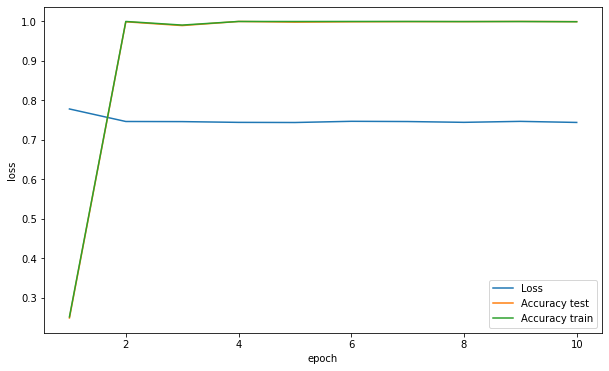

In [14]:
plotLearning(results)

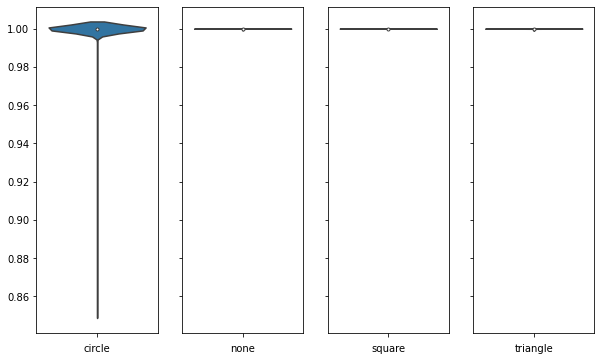

In [15]:
fig, axs = plt.subplots(1,4, sharey=True, figsize=(10,6))
for i in range(4):
    sns.violinplot(y = y_pred[y_pred.argmax(1) == i, i], ax=axs[i])
    axs[i].set_xlabel(CLASSES[i])

In [16]:
indexes = np.array([get_random_4_best_ids(i) for i in range(len(CLASSES))]).flatten()

In [17]:
indexes.sort()

In [18]:
i = 0
x_test = []
for batch in test_loader:
    inputs = batch[0]
    for x in inputs:
        if i in indexes:
            x_test.append(x.numpy())
        i += 1

In [23]:
np.c_[y_pred[indexes].argmax(1), y_true[indexes]]

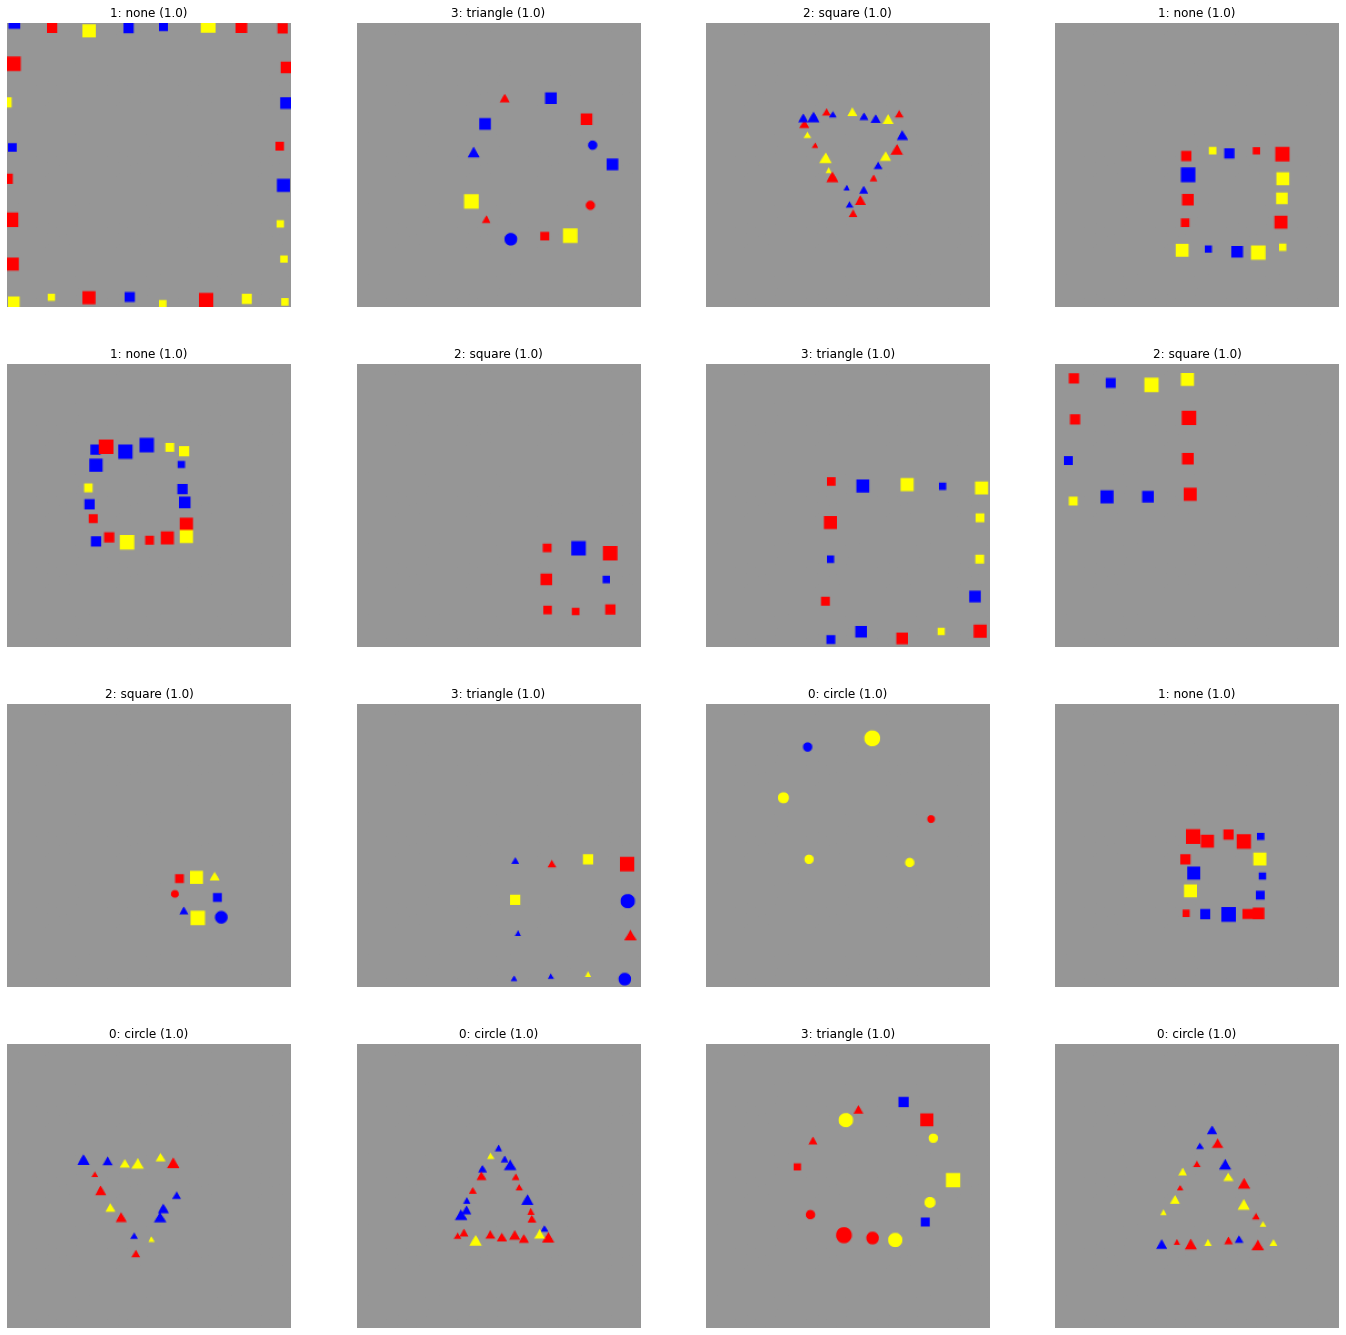

In [19]:
show_images(x_test, y_pred[indexes], 4)

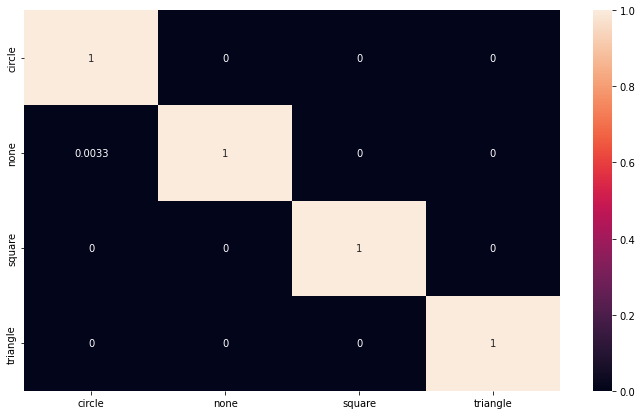

In [101]:
plot_confusion_matrix(y_true, y_pred.argmax(1))